# Temporal Difference

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [ ]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import random

import matplotlib.pyplot as plt
%matplotlib inline

### Helpers

In [ ]:
import seaborn as sns
sns.set_style("white")

def plot_values(V):
	# reshape the state-value function
	V = np.reshape(V, (4,12))
	# plot the state-value function
	fig = plt.figure(figsize=(15,5))
	ax = fig.add_subplot(111)
	im = ax.imshow(V, cmap='cool')
	for (j,i),label in np.ndenumerate(V):
	    ax.text(i, j, np.round(label,3), ha='center', va='center', fontsize=14)
	plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
	plt.title('State-Value Function')
	plt.show()


In [ ]:
import unittest 
from IPython.display import Markdown, display
import numpy as np

def printmd(string):
    display(Markdown(string))

V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

pol_opt = np.hstack((np.ones(11), 2, 0))

V_true = np.zeros((4,12))
for i in range(3):
    V_true[0:13][i] = -np.arange(3, 15)[::-1] - i
V_true[1][11] = -2
V_true[2][11] = -1
V_true[3][0] = -17

def get_long_path(V):
    return np.array(np.hstack((V[0:13][0], V[1][0], V[1][11], V[2][0], V[2][11], V[3][0], V[3][11])))

def get_optimal_path(policy):
    return np.array(np.hstack((policy[2][:], policy[3][0])))

class Tests(unittest.TestCase):

    def td_prediction_check(self, V):
        to_check = get_long_path(V)
        soln = get_long_path(V_true)
        np.testing.assert_array_almost_equal(soln, to_check)

    def td_control_check(self, policy):
        to_check = get_optimal_path(policy)
        np.testing.assert_equal(pol_opt, to_check)

check = Tests()

def run_check(check_name, func):
    try:
        getattr(check, check_name)(func)
    except check.failureException as e:
        printmd('**<span style="color: red;">PLEASE TRY AGAIN</span>**')
        return
    printmd('**<span style="color: green;">PASSED</span>**')

In [ ]:
# create an instance of the CliffWalking environment
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [ ]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

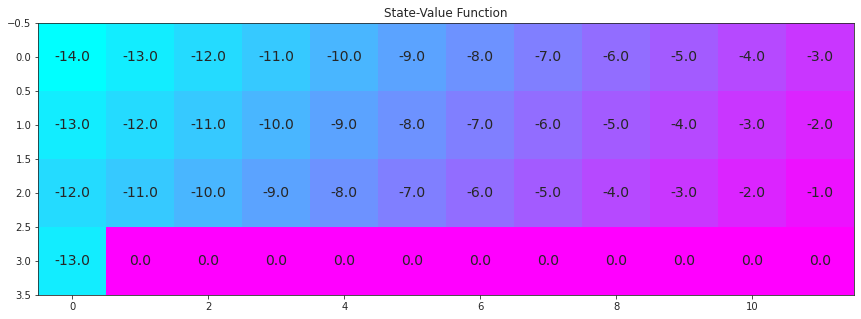

In [ ]:
# define the optimal state-value function

v_opt = np.zeros((4, 12))

v_opt[0:13][0] = -np.arange(3, 15)[::-1]
v_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
v_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
v_opt[3][0] = -13

plot_values(v_opt)

### Part 1: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.


In [ ]:
def update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state=None, next_action=None):
    """Returns updated Q-value for the most recent experience."""
    # estimate in Q-table (for current state, action pair)
    current = Q[state][action]
    
    # get value of state, action pair at next time step
    Qsa_next = Q[next_state][next_action] if next_state is not None else 0

    # construct TD target
    target = reward + (gamma * Qsa_next)
    # get updated value
    return current + (alpha * (target - current))

In [ ]:
def epsilone_greedy(Q: dict, state: int, num_of_actions: int, eps: float):
    """
    Selects epsilon-greedy action for supplied state.
    
    Params
    ======
        Q (dictionary): action-value function
        state (int): current state
        num_of_actions (int): number actions in the environment
        eps (float): epsilon
    """

    # select greedy action with probability epsilon
    if random.random() > eps:
        return np.argmax(Q[state])

    # otherwise, select an action randomly
    return random.choice(np.arange(env.action_space.n))

In [ ]:
def sarsa(env, num_episodes: int, alpha: float, gamma: float = 1.0, plot_every: int = 100):
    # initialize action-value function (empty dictionary of arrays)
    num_of_actions = env.action_space.n
    Q = defaultdict(lambda: np.zeros(num_of_actions))

    # deque for keeping track of scores
    tmp_scores = deque(maxlen=plot_every)
    # average scores over every plot_every episodes
    avg_scores = deque(maxlen=num_episodes)

    # initialize performance monitor. Loop over episodes
    for i_episode in range(1, num_episodes + 1):
        # monitor progress
        if i_episode % 10 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # initialize score
        score = 0
        # start episode
        state = env.reset()

        # set value of epsilon
        eps = 1.0 / i_episode
        # epsilon-greedy action selection
        action = epsilone_greedy(Q, state, num_of_actions, eps)

        while True:
            # take action A, observe R, S'
            next_state, reward, done, info = env.step(action)
            # add reward to agent's score
            score += reward

            if done:
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, state, action, reward)

                # append score
                tmp_scores.append(score)
                break
            else:
                # epsilon-greedy action
                next_action = epsilone_greedy(Q, next_state, num_of_actions, eps)
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state, next_action)

                # S <- S'
                state = next_state
                # A <- A'
                action = next_action

        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
        
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()

    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))

    return Q


Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
Episode 5000/5000

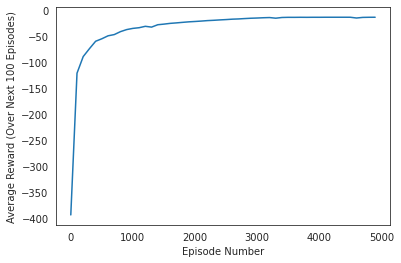

Best Average Reward over 100 Episodes:  -13.0


In [ ]:
%time

# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 5000, 0.01)

In [ ]:
# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  1  0  1  1  1  2  1  1  2  1  2]
 [ 1  3  0  0  2  1  1  2  1  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


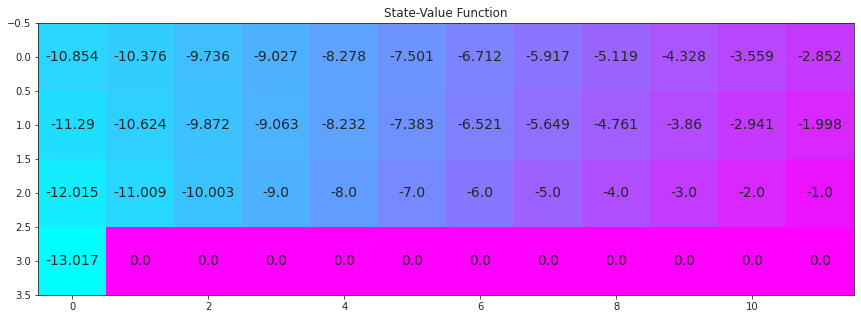

In [ ]:
# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

### Part 2: TD Control: Q-learning

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.


In [ ]:
def update_Q_sarsamax(alpha, gamma, Q, state, action, reward, next_state=None):
    """Returns updated Q-value for the most recent experience."""

    # estimate in Q-table (for current state, action pair)
    current = Q[state][action]

    # value of next state 
    Qsa_next = np.max(Q[next_state]) if next_state is not None else 0

    # construct TD target
    target = reward + (gamma * Qsa_next)

    # get updated value 
    return current + (alpha * (target - current))

In [ ]:
def q_learning(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    """Q-Learning - TD Control
    
    Params
    ======
        num_episodes (int): number of episodes to run the algorithm
        alpha (float): learning rate
        gamma (float): discount factor
        plot_every (int): number of episodes to use when calculating average score
    """
    num_of_actions = env.action_space.n
    Q = defaultdict(lambda: np.zeros(num_of_actions))

    # monitor performance
    # deque for keeping track of scores
    tmp_scores = deque(maxlen=plot_every)
    # average scores over every plot_every episodes
    avg_scores = deque(maxlen=num_episodes)

    for i_episode in range(1, num_episodes + 1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # initialize score
        score = 0
        # start episode
        state = env.reset()
        # set value of epsilon
        eps = 1.0 / i_episode

        while True:
            # epsilon-greedy action selection
            action = epsilone_greedy(Q, state, num_of_actions, eps)
            # take action A, observe R, S'
            next_state, reward, done, info = env.step(action)
            # add reward to agent's score
            score += reward

            Q[state][action] = update_Q_sarsamax(alpha, gamma, Q, state, action, reward, next_state)
            # S <- S'
            state = next_state

            if done:
                tmp_scores.append(score)
                break

        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))

    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 50000/50000

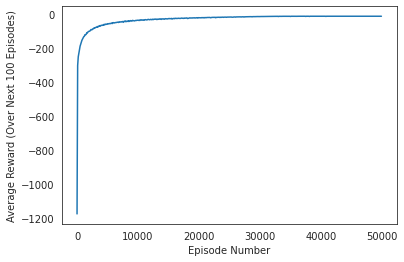

Best Average Reward over 100 Episodes:  -13.0


In [ ]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 50000, 0.001)

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  1  1  0  1  2  2  1  2  2  2  2]
 [ 1  1  1  1  1  1  1  1  2  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


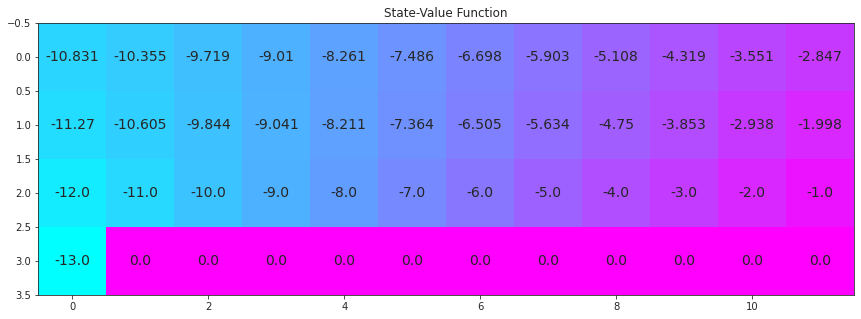

In [ ]:
# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Part 3: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.


In [ ]:
def update_Q_expsarsa(alpha, gamma, nA, eps, Q, state, action, reward, next_state=None):
    """Returns updated Q-value for the most recent experience."""
    current = Q[state][action]         # estimate in Q-table (for current state, action pair)
    policy_s = np.ones(nA) * eps / nA  # current policy (for next state S')
    policy_s[np.argmax(Q[next_state])] = 1 - eps + (eps / nA) # greedy action
    Qsa_next = np.dot(Q[next_state], policy_s)         # get value of state at next time step
    target = reward + (gamma * Qsa_next)               # construct target
    
    # get updated value 
    return current + (alpha * (target - current))

In [ ]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    """Expected SARSA - TD Control
    
    Params
    ======
        num_episodes (int): number of episodes to run the algorithm
        alpha (float): step-size parameters for the update step
        gamma (float): discount factor
        plot_every (int): number of episodes to use when calculating average score
    """
    nA = env.action_space.n                # number of actions
    Q = defaultdict(lambda: np.zeros(nA))  # initialize empty dictionary of arrays
    
    # monitor performance
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)   # average scores over every plot_every episodes
    
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        score = 0             # initialize score
        state = env.reset()   # start episode
        eps = 0.005           # set value of epsilon
        
        while True:
            action = epsilone_greedy(Q, state, nA, eps)         # epsilon-greedy action selection
            next_state, reward, done, info = env.step(action)  # take action A, observe R, S'
            score += reward                                    # add reward to agent's score
            # update Q
            Q[state][action] = update_Q_expsarsa(alpha, gamma, nA, eps, Q, \
                                                 state, action, reward, next_state)        
            state = next_state              # S <- S'
            if done:
                tmp_scores.append(score)    # append score
                break
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
            
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

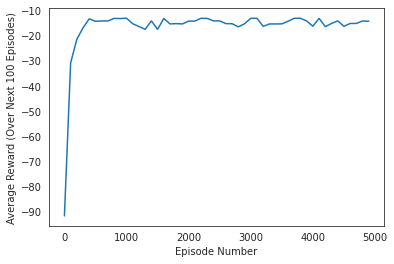

Best Average Reward over 100 Episodes:  -13.04


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  2  1  1  1  1  1  2  1  1  2]
 [ 0  0  1  1  0  1  2  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


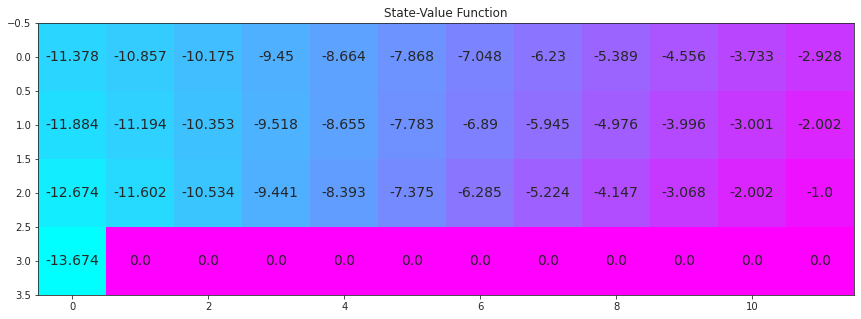

In [ ]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 5000, 0.1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])